In [1]:
from google.colab import drive

drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
casos_df = pd.read_excel('/content/drive/MyDrive/semilleroEstadistica/CasosVS_202309.xlsx')
victimas_df = pd.read_excel('/content/drive/MyDrive/semilleroEstadistica/VictimasVS_202309.xlsx')

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [4]:
def clean_column_names(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace(r'\W', '', regex=True)
    return df

casos_df_clean = clean_column_names(casos_df.copy())
victimas_df_clean = clean_column_names(victimas_df.copy())



In [29]:
# redefinición de columnas de un dataframe con maximo 20 caracteres por columnas
def shorten_column_names(df):
    abbreviations = {
        'id_caso': 'id_caso',
        'id_caso_relacionado': 'id_caso_rel',
        'año': 'anho',
        'mes': 'mes',
        'día': 'dia',
        'código_dane_de_municipio': 'cod_dane_mun',
        'municipio': 'municipio',
        'departamento': 'depto',
        'región': 'región',
        'modalidad': 'modalidad',
        'presunto_responsable': 'presunto_resp',
        'descripción_presunto_responsable': 'desc_presunto_resp',
        'abandono_o_despojo_forzado_de_tierras': 'aband_desp_tierras',
        'amenaza_o_intimidación': 'amenaza_intimid',
        'ataque_contra_misión_médica': 'ataq_mis_med',
        'confinamiento_o_restricción_a_la_movilidad': 'conf_restr_mov',
        'desplazamiento_forzado': 'desplaz_forzado',
        'extorsión': 'extorsión',
        'lesionados_civiles': 'lesion_civiles',
        'pillaje': 'pillaje',
        'tortura': 'tortura',
        'violencia_basada_en_género': 'viol_gen',
        'otro_hecho_simultáneo': 'otro_hecho_sim',
        'total_de_víctimas_del_caso': 'total_vict_caso',
        'tipo_de_armas': 'tipo_armas',
        'latitud': 'latitud',
        'longitud': 'longitud',
        'id_persona': 'id_persona',
        'sexo': 'sexo',
        'etnia': 'etnia',
        'ocupación': 'ocupación',
        'calidad_de_la_víctima_o_la_baja': 'cal_vict_baja',
        'tipo_de_población_vulnerable': 'tipo_pob_vuln',
        'militante_político': 'milit_político',
        'fuerza_o_grupo_armado_organizado_al_que_pertenece_el_combatiente': 'fuerza_grupo_arm',
        'descripción_fuerza_o_grupo_armado_organizado_al_que_pertenece_el_combatiente': 'desc_fuerza_arm',
        'situación_actual_de_la_víctima': 'sit_act_victima',
        'edad': 'edad'
    }

    df.columns = [abbreviations.get(col, col)[:20] for col in df.columns]
    return df

casos_df_short = shorten_column_names(casos_df_clean.copy())
victimas_df_short = shorten_column_names(victimas_df_clean.copy())

updated_columns = {
    "Casos Dataset Columns": casos_df_short.columns.tolist(),
    "Victimas Dataset Columns": victimas_df_short.columns.tolist()
}

updated_columns


{'Casos Dataset Columns': ['id_caso',
  'id_caso_rel',
  'anho',
  'mes',
  'dia',
  'cod_dane_mun',
  'municipio',
  'depto',
  'región',
  'modalidad',
  'presunto_resp',
  'desc_presunto_resp',
  'aband_desp_tierras',
  'amenaza_intimid',
  'ataq_mis_med',
  'conf_restr_mov',
  'desplaz_forzado',
  'extorsión',
  'lesion_civiles',
  'pillaje',
  'tortura',
  'viol_gen',
  'otro_hecho_sim',
  'total_vict_caso',
  'tipo_armas',
  'latitud',
  'longitud'],
 'Victimas Dataset Columns': ['id_caso',
  'cod_dane_mun',
  'municipio',
  'depto',
  'anho',
  'mes',
  'dia',
  'id_persona',
  'sexo',
  'etnia',
  'ocupación',
  'cal_vict_baja',
  'tipo_pob_vuln',
  'milit_político',
  'fuerza_grupo_arm',
  'desc_fuerza_arm',
  'sit_act_victima',
  'edad',
  'latitud',
  'longitud']}

In [ ]:
# Define a function to identify missing or placeholder values
def identify_missing_or_placeholder(df):
    # Placeholder values that might be considered as missing data
    placeholders = ["SIN INFORMACION", "DESCONOCIDO", "ND", "0", 0, "NaN", ""]

    missing_values = df.isnull().mean() * 100

    placeholder_values = df.apply(lambda col: col.isin(placeholders).mean()) * 100

    missing_info = pd.DataFrame({'missing_percentage': missing_values, 'placeholder_percentage': placeholder_values})
    missing_info['total_impacted'] = missing_info.sum(axis=1)

    return missing_info.sort_values(by='total_impacted', ascending=False)

missing_info_casos = identify_missing_or_placeholder(casos_df_short)
missing_info_victimas = identify_missing_or_placeholder(victimas_df_short)

missing_info_casos, missing_info_victimas


In [27]:
# treshhold de calidad de información basado en los valores arriba
import numpy as np

threshold_percentage = 95
# Eliminar columnas con 95% missing/placeholder data de ambos archivos
casos_df_cleaned = casos_df_short.drop(columns=missing_info_casos[missing_info_casos['total_impacted'] > threshold_percentage].index)
victimas_df_cleaned = victimas_df_short.drop(columns=missing_info_victimas[missing_info_victimas['total_impacted'] > threshold_percentage].index)

#Organizar datos que son marcados por defecto
for column in ['anho', 'mes', 'dia']:
    casos_df_cleaned[column] = np.where(casos_df_cleaned[column] == 0, pd.NA, casos_df_cleaned[column])
    victimas_df_cleaned[column] = np.where(victimas_df_cleaned[column] == 0, pd.NA, victimas_df_cleaned[column])

updated_info = {
    "Casos Dataset Shape": casos_df_cleaned.shape,
    "Victimas Dataset Shape": victimas_df_cleaned.shape,
    "Sample Año (Casos)": casos_df_cleaned['anho'].dropna().unique()[:5],
    "Sample Año (Victimas)": victimas_df_cleaned['anho'].dropna().unique()[:5]
}

updated_info


{'Casos Dataset Shape': (16478, 19),
 'Victimas Dataset Shape': (17331, 16),
 'Sample Año (Casos)': array([1997, 2001, 1999, 2004, 2002], dtype=object),
 'Sample Año (Victimas)': array([1997, 2001, 1999, 2004, 2002], dtype=object)}

In [26]:

casos_df_nodup = casos_df_cleaned.drop_duplicates(casos_df_cleaned.columns.difference(['id_caso']))
victimas_df_nodup = victimas_df_cleaned.drop_duplicates(victimas_df_cleaned.columns.difference(['id_persona']))


unique_modalidades = casos_df_nodup['modalidad'].unique()
unique_deptos = casos_df_nodup['depto'].unique()

validation_info = {
    "Casos Dataset Shape Before": casos_df_cleaned.shape,
    "Casos Dataset Shape After Duplicate Removal": casos_df_nodup.shape,
    "Victimas Dataset Shape Before": victimas_df_cleaned.shape,
    "Victimas Dataset Shape After Duplicate Removal": victimas_df_nodup.shape,
    "Unique Modalidades": unique_modalidades[:5],  # Display a sample for brevity
    "Unique Deptos": unique_deptos[:5]
}

validation_info


{'Casos Dataset Shape Before': (16478, 19),
 'Casos Dataset Shape After Duplicate Removal': (15223, 19),
 'Victimas Dataset Shape Before': (17331, 16),
 'Victimas Dataset Shape After Duplicate Removal': (16916, 16),
 'Unique Modalidades': array(['RETENCIÓN/EJECUCIÓN', 'ASALTO', 'DESCONOCIDA', 'COERCIÓN',
        'ENGAÑO LABORAL'], dtype=object),
 'Unique Deptos': array(['CALDAS', 'SANTANDER', 'CESAR', 'SIN INFORMACION',
        'NORTE DE SANTANDER'], dtype=object)}

#  Temporal Analysis: Yearly counts of cases and victims


In [25]:
# casos por año
cases_yearly = casos_df_nodup['anho'].value_counts().sort_index()
#victimas por año
victims_yearly = victimas_df_nodup['anho'].value_counts().sort_index()

# dataframe a visualizar
yearly_data = pd.DataFrame({
    'Cases': cases_yearly,
    'Victims': victims_yearly
}).fillna(0)
yearly_data.head()


,Cases,Victims
1959,2,2
1960,2,2
1961,6,6
1962,7,9
1963,2,2


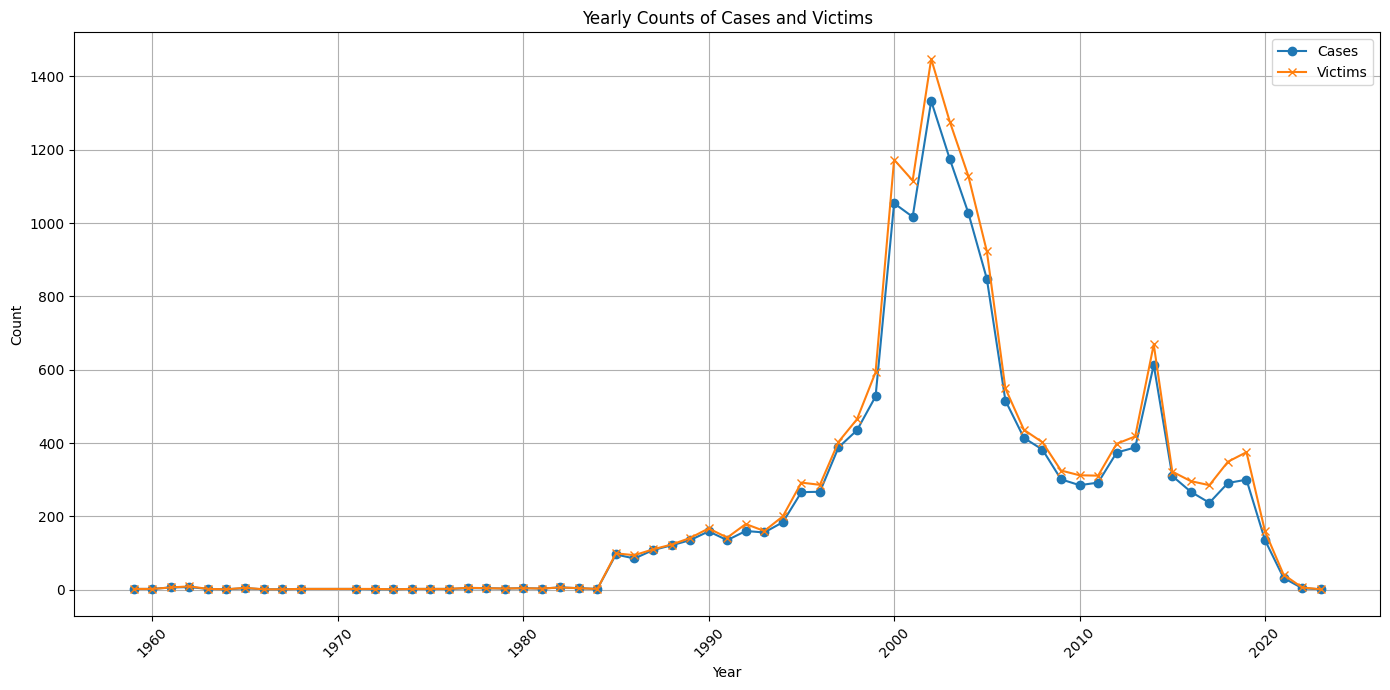

In [24]:
import matplotlib.pyplot as plt

# Visualization of yearly data
plt.figure(figsize=(14, 7))
plt.plot(yearly_data.index, yearly_data['Cases'], label='Cases', marker='o')
plt.plot(yearly_data.index, yearly_data['Victims'], label='Victims', marker='x')
plt.title('Yearly Counts of Cases and Victims')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [23]:
cases_by_dept = casos_df_nodup['depto'].value_counts().sort_values(ascending=False)

victims_by_dept = victimas_df_nodup.groupby('depto').size().sort_values(ascending=False)

dept_distribution = pd.DataFrame({
    'Cases': cases_by_dept,
    'Victims': victims_by_dept
}).fillna(0)

#Top 10 departamentos
dept_distribution.head(10)


,Cases,Victims
AMAZONAS,11,12
ANTIOQUIA,2863,3089
ARAUCA,167,182
"ARCHIPIELAGO DE SAN ANDRES, PROVIDENCIA Y SANTA CATALINA",1,1
ATLANTICO,49,54
"BOGOTA, D. C.",81,100
BOLIVAR,944,1025
BOYACA,106,118
CALDAS,175,185
CAQUETA,653,705


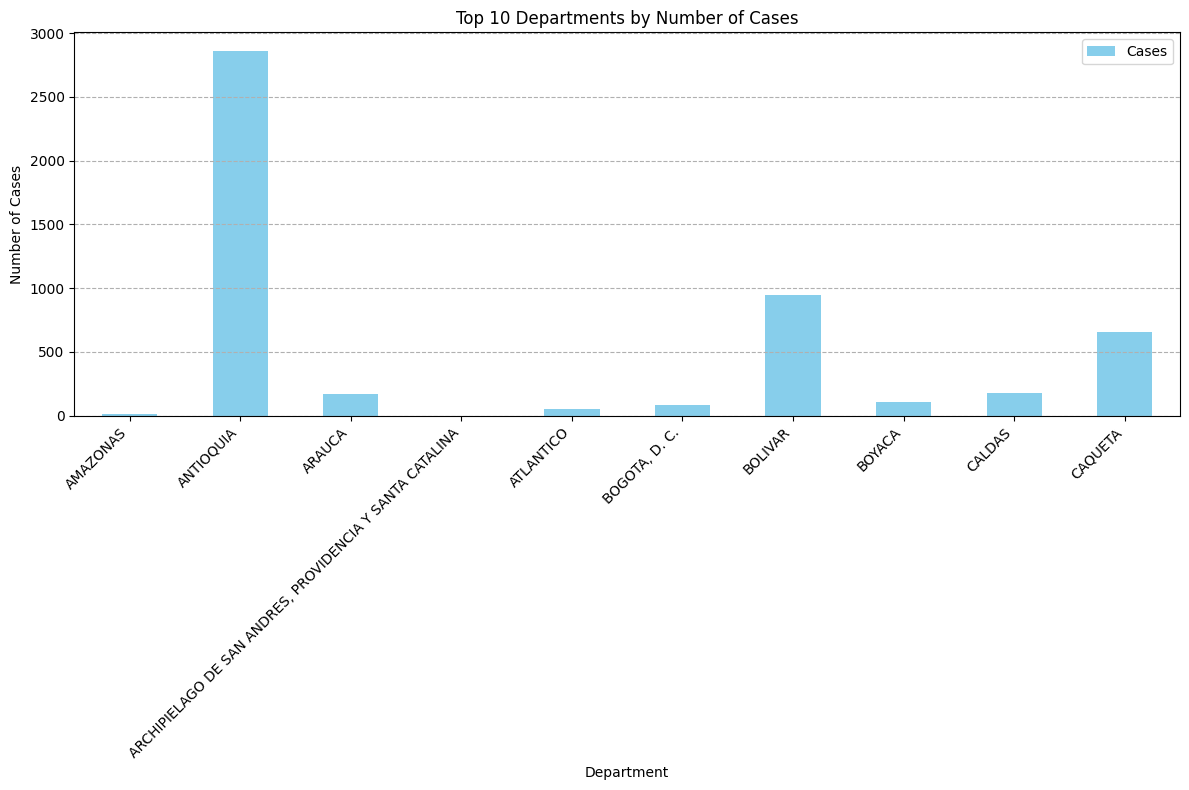

In [22]:
#Top Ten Departments
top_depts = dept_distribution.head(10)

plt.figure(figsize=(12, 8))
top_depts['Cases'].plot(kind='bar', color='skyblue', label='Cases')
plt.title('Top 10 Departments by Number of Cases')
plt.xlabel('Department')
plt.ylabel('Number of Cases')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()
